In [1]:
#import library
from src import utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,f1_score
import json

In [2]:
# definen x valid,y valid, and threshold_results
X_valid = utils.deserialized_data("data/processed/X_valid_prep.pkl")
y_valid = utils.deserialized_data("data/processed/y_valid_prep.pkl")
trained_models = utils.deserialized_data("models/trained_models.pkl")

In [3]:
def threshold_tuning(model, X_valid, y_valid):
    """
    Performs threshold tuning for the given model and plots the results.
    
    Parameters:
        model: The trained model instance.
        X_valid: Validation features.
        y_valid: Validation labels.
    
    Returns:
        Returns:
        List of dictionaries:
            Each dictionary contains the following keys:
                - 'threshold': The threshold value used for classification.
                - 'recall': Recall score at the given threshold.
                - 'f1-score': F1-score at the given threshold.
                - 'accuracy': Accuracy score at the given threshold.
                - 'weighted_f1': Weighted F1-score at the given threshold.
    """
    thresholds = np.linspace(0, 1, 100)  # Generate 100 thresholds from 0 to 1
    metrics = []

    # Get predicted probabilities for the positive class
    y_probs = model.predict_proba(X_valid)[:, 1]

    for threshold in thresholds:
        # Apply the threshold to get predicted classes
        y_pred = (y_probs >= threshold).astype(int)
        
        # Calculate weighted F1 score
        weighted_f1 = f1_score(y_valid, y_pred, average='weighted')
        # Generate classification report for the current threshold
        report = classification_report(y_valid, y_pred, output_dict=True,zero_division=0)
        
        # Collect metrics of interest (e.g., recall, f1-score, accuracy)
        metrics.append({
            'threshold': threshold,
            'recall': report['1']['recall'],
            'f1-score': report['1']['f1-score'],
            'accuracy': report['accuracy'],
            'weighted_f1': weighted_f1
        })

    # Convert metrics to DataFrame for easier plotting
    metrics_df = pd.DataFrame(metrics)

    # Plotting metrics vs. thresholds using Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='threshold', y='recall', label='Recall', color='blue')
    sns.lineplot(data=metrics_df, x='threshold', y='f1-score', label='F1-Score', color='green')
    sns.lineplot(data=metrics_df, x='threshold', y='accuracy', label='Accuracy', color='red')
    sns.lineplot(data=metrics_df, x='threshold', y='weighted_f1', label='Weighted F1', color='orange')
    
    plt.title(f'Threshold Tuning for {model.__class__.__name__}')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()

    return metrics

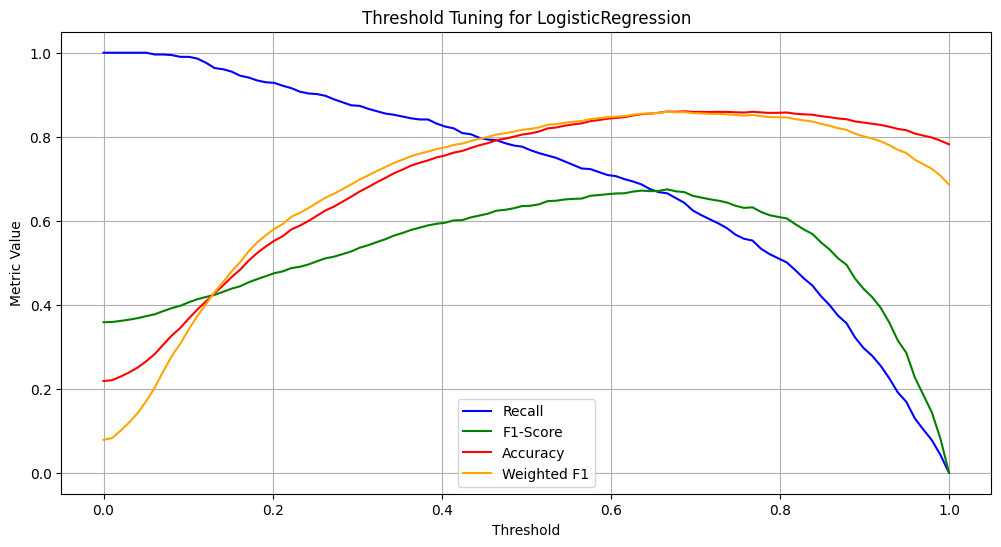

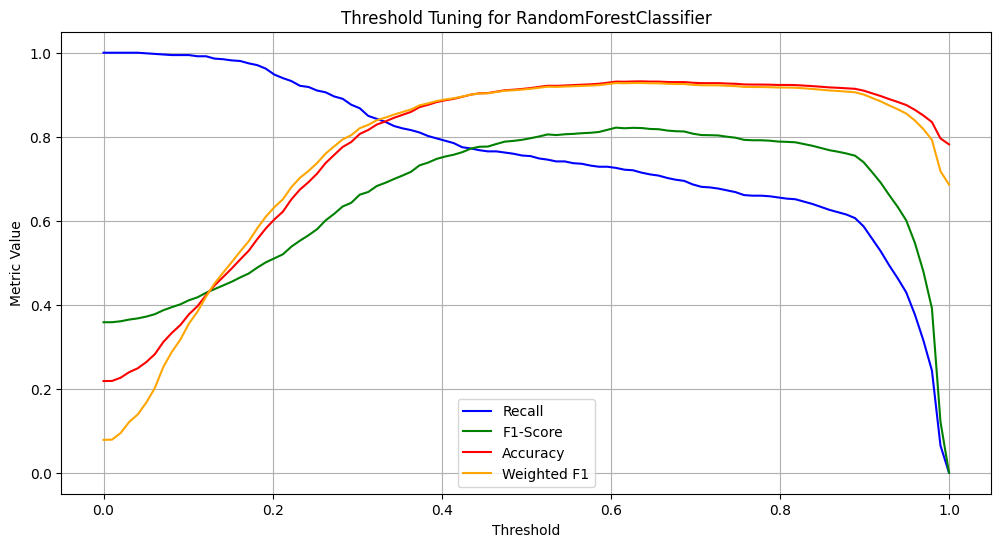

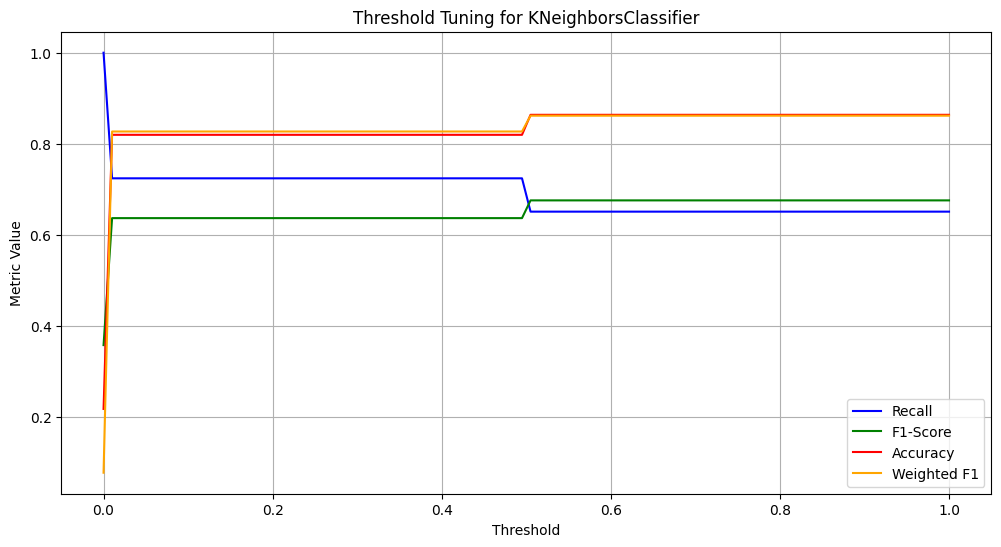

In [4]:
threshold_results = {} 
for name, model in trained_models.items(): 
    threshold_results[name] = threshold_tuning(model.best_estimator_, X_valid, y_valid)
    utils.serialize_data(threshold_results, f'models/{name}_threshold.pkl')  # Save the model

In [5]:
def best_tuning_threshold(threshold_results, json_path):
    """
    Selects the best threshold for each model based on the F1-score metric and saves the results to a JSON file.
    
    Parameters:
        threshold_results (dict): A dictionary where each key is a model name and each value is a list of metrics (threshold, f1-score).
        json_path (str): The path where the JSON file with the best thresholds will be saved.
    
    Returns:
        best_thresholds (dict): A dictionary where each key is a model name and each value is the best threshold for that model.
    """
    best_thresholds = {}
    results = []  # List to store results for JSON
    
    for model_name, metrics in threshold_results.items():
        # Convert metrics to a DataFrame
        metrics_df = pd.DataFrame(metrics)
        
        # Sort by the desired metric (e.g., 'f1-score') in descending order
        best_metric_row = metrics_df.sort_values(by='weighted_f1', ascending=False).iloc[0]
        
        # Extract the best threshold and model name
        best_threshold = best_metric_row['threshold']
        best_thresholds[model_name] = best_threshold

        # Append the results for saving later
        results.append({
            'best_model': model_name,
            'best_threshold': best_threshold,
            'f1-score': best_metric_row['weighted_f1']
        })

    # Save all best thresholds information to a JSON file
    with open(json_path, 'w') as f:
        json.dump(results, f)

    print("Best Thresholds for Each Model:", best_thresholds)
    return best_thresholds

In [6]:
best_threshold = best_tuning_threshold(threshold_results,"models/best_threshold.json")
print(f'Selected best threshold: {best_threshold}')

Best Thresholds for Each Model: {'LogisticRegression': 0.6666666666666667, 'RandomForestClassifier': 0.6363636363636365, 'KNN': 0.5050505050505051}
Selected best threshold: {'LogisticRegression': 0.6666666666666667, 'RandomForestClassifier': 0.6363636363636365, 'KNN': 0.5050505050505051}


In [8]:
with open("models/best_threshold.json", 'r') as f:
    best_thresholds=json.load(f)
print(best_thresholds)

[{'best_model': 'LogisticRegression', 'best_threshold': 0.6666666666666667, 'f1-score': 0.8593122079472155}, {'best_model': 'RandomForestClassifier', 'best_threshold': 0.6363636363636365, 'f1-score': 0.9279840610365604}, {'best_model': 'KNN', 'best_threshold': 0.5050505050505051, 'f1-score': 0.8618222892545848}]


Random Forest achieves the highest metrics after threshold tuning, it indicates that this model is the most effective among the tested algorithms for predicting credit risk.

In [9]:
X_test = utils.deserialized_data("data/processed/X_test_prep.pkl")
y_test = utils.deserialized_data("data/processed/y_test_prep.pkl")

In [10]:
def evaluate_model(model, thresholds, X_test, y_test):
    """
    Evaluates the performance of a classification model using specified thresholds 
    and prints the classification report for each model.

    This function generates predicted probabilities for the positive class from the 
    provided model and applies the given thresholds to classify the predictions. 
    It then prints a detailed classification report that includes precision, recall, 
    F1-score, and support for each class.

    Parameters:
        model: A trained classification model that implements the `predict_proba` method.
        thresholds: dict
            A dictionary where keys are model names (or identifiers) and values are 
            the corresponding thresholds to be used for classification.
        X_test: array-like, shape (n_samples, n_features)
            Test features used to generate predicted probabilities.
        y_test: array-like, shape (n_samples,)
            True binary labels for the test set.

    Returns:
        None: This function prints the classification reports directly to the console 
        and does not return any values.
    """
    # Make predictions
    # Print classification report for each model
    for model_name, thresholds in thresholds.items():
        print(f"Classification Report for {model_name} :")
        y_probabilities = model.predict_proba(X_test)[:,1]
        y_preds=(y_probabilities>= thresholds).astype(int)
        print(classification_report(y_test,y_preds))


In [11]:
model_results = {} 
for name, model in trained_models.items(): 
    model_results[name] = evaluate_model(model.best_estimator_, best_threshold, X_test, y_test)

Classification Report for LogisticRegression :
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2548
           1       0.69      0.67      0.68       711

    accuracy                           0.86      3259
   macro avg       0.80      0.79      0.80      3259
weighted avg       0.86      0.86      0.86      3259

Classification Report for RandomForestClassifier :
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2548
           1       0.66      0.69      0.68       711

    accuracy                           0.86      3259
   macro avg       0.79      0.80      0.79      3259
weighted avg       0.86      0.86      0.86      3259

Classification Report for KNN :
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2548
           1       0.57      0.78      0.66       711

    accuracy                           0.82      325

Because the user want to know more accurate to predict the default credit, Using the classification reports provided for the three models:

1. Logistic Regression

    Default (1):
    - Precision: 0.69 (69% of predicted defaults are actual defaults)
    - Recall: 0.67 (67% of actual defaults are correctly predicted)
    - F1-Score: 0.68 (a balance between precision and recall for defaults)


2. Random Forest Classifier

    Default (1):
    - Precision: 0.66 (66% of predicted defaults are actual defaults)
    - Recall: 0.69 (69% of actual defaults are correctly predicted)
    - F1-Score: 0.68 (indicating balanced performance for defaults)

   
3. K-Nearest Neighbors (KNN)

    Default (1):
    - Precision: 0.57 (57% of predicted defaults are actual defaults)
    - Recall: 0.78 (78% of actual defaults are correctly predicted)
    - F1-Score: 0.66 (indicating some room for improvement)


### Summary :
1. Optimal Model Selection:

    - When Random Forest achieves the highest metrics after threshold tuning, it indicates that this model is the most effective among the tested algorithms for predicting credit risk.

    - Metrics such as accuracy, precision, recall, F1-score are critical in assessing model performance.

2. Model Performance for Defaults (1):

    - Logistic Regression: Best performance with a precision of 0.69  and an F1-score of 0.68, indicating it effectively identifies defaults.

    - Random Forest: Similar to Logistic Regression with a precision of 0.66 and an F1-score of 0.68, showing balanced performance but slightly lower precision.
    
    - K-Nearest Neighbors (KNN): Lowest precision at 0.57 for predicting defaults, indicating it struggles to accurately identify defaults.
    
3. Robustness and Generalization:

    - Random Forest's ensemble approach, which combines multiple decision trees, helps in reducing overfitting and enhances the model's ability to generalize well to unseen data.

    - This robustness is particularly important in credit risk modeling, where the cost of misclassification can be significant.


### Conclusion :
The conclusion that Random Forest has the highest metrics after threshold tuning signifies its effectiveness as a predictive tool in credit risk modeling. It not only enhances predictive accuracy but also provides valuable insights into the factors influencing credit risk, ultimately supporting better decision-making in financial institutions. While the models show good overall performance, particularly for non-defaults, there is a need for improvement in accurately predicting defaults (1). Implementing the above strategies can enhance the model's predictive capabilities in identifying credit risk more effectively. 